# Linear in means model

Following notebook runs a test of structural adversarial estimation of linear in means peer effect model of a form:
$$ y_i = a + b \cdot  1/|\mathcal{N(i)}| \sum_{j \in \mathcal{N(i)}} x_j + \varepsilon_i$$

Where $y_i$ is a scalar outcome of node $i$, $\mathcal{N(i)}$ is set of $i$'s neighbours and $x_j$ is some characteristic of $j$ exogenous to the structural model.
Ultimately, such model can be easily estimated with cross-sectional OLS but this experiment shows that our method works for trivial case, and for 2 parameter model we are able to visualize objective and optimization path. The discriminator is simple GNN with a single convolutional layer and linear classifier and we use ego sampling of depth 1 to create the training sample. Outside minimization problem of the adversarial objective is solved with surrogate optimization using GP as model of expected improvement.

## Imports

In [7]:
import warnings
warnings.filterwarnings("ignore", message="An issue occurred while importing 'torch-sparse'")
warnings.filterwarnings("ignore", message="An issue occurred while importing 'torch-cluster'")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

from adversarial_nets import (
    AdversarialEstimator,
    GraphDataset,
    objective_function
)

## Test dataset 

In [8]:
N_NODES = 2500
N_SAMPLES = 2000
N_EPOCHS = 6
RESOLUTION = 10
P = 0.01

def create_test_graph_dataset(
    num_nodes: int = 100,
    true_a: float = 1.0,
    true_b: float = 2.0,
    p: float = 0.01,
    seed: int = 42
) -> GraphDataset:
    """Generate a test graph dataset for a linear-in-means model."""
    
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    G = nx.erdos_renyi_graph(n=num_nodes, p=p, seed=seed)
    A = nx.adjacency_matrix(G).todense()  
    X = np.random.randn(num_nodes, 1)

    Y = np.zeros((num_nodes, 1))
    for i in range(num_nodes):
        neighbors = list(G.neighbors(i))
        if neighbors:
            mean_neighbor_x = np.mean(X[neighbors], axis=0)
        else:
            mean_neighbor_x = 0.0
        Y[i] = true_a + true_b * mean_neighbor_x + np.random.normal(0.0, 0.1)

    N = list(range(num_nodes))

    return GraphDataset(X=X, Y=Y, A=A, N=N)

## Structural model mapping

In [9]:
from numba import njit, prange

@njit(parallel=True)
def linear_in_means_model(x, peer_operator, y0, theta):
    """
    Numba-optimized linear-in-means model with automatic parallelization.
    
    Parameters:
    -----------
    x : numpy.ndarray
        Node features (n × k) - must be C-contiguous
    peer_operator : numpy.ndarray
        Peer operator with zero diagonal (n × n) - must be C-contiguous
    y0 : numpy.ndarray
        Initial outcomes (ignored in this simple model)
    theta : tuple or list
        Parameters (a, b) - pass as tuple for better Numba performance
    
    Returns:
    --------
    numpy.ndarray
        Generated outcomes (n × 1)
    """
    a, b = theta[0], theta[1]
    n = x.shape[0]
    y = np.zeros((n, 1), dtype=x.dtype)
    
    for i in prange(n):
        neighbor_sum = 0.0
        neighbor_count = 0
        
        for j in range(n):
            if peer_operator[i, j] > 0:
                neighbor_sum += x[j, 0]
                neighbor_count += 1
        
        if neighbor_count > 0:
            mean_neighbor_x = neighbor_sum / neighbor_count
        else:
            mean_neighbor_x = 0.0
            
        y[i, 0] = a + b * mean_neighbor_x
    
    return y

In [10]:
def discriminator_factory(input_dim, hidden_dim=16, num_classes=2):
    class SimpleGNN(nn.Module):
        def __init__(self, in_dim, hid_dim, num_cls):
            super().__init__()
            self.conv = GCNConv(in_dim, hid_dim)
            self.classifier = nn.Linear(hid_dim, num_cls)

        def forward(self, data):
            x, edge_index, batch = data.x, data.edge_index, data.batch
            x = F.relu(self.conv(x, edge_index))
            x = F.dropout(x, p=0.2, training=self.training)
            x = global_mean_pool(x, batch)
            return self.classifier(x)

    return SimpleGNN(input_dim, hidden_dim, num_classes)

## Visualization utils 

In [11]:
def visualize_objective_surface(estimator, m, resolution, num_epochs, verbose=False):
    a_range = np.linspace(-3, 5, resolution)
    b_range = np.linspace(-1, 5, resolution)
    A, B = np.meshgrid(a_range, b_range)

    Z = np.zeros_like(A)

    total_evals = resolution * resolution
    with tqdm(total=total_evals, desc="Evaluating objective surface") as pbar:
        for i in range(resolution):
            for j in range(resolution):
                theta = [A[i, j], B[i, j]]
                Z[i, j] = objective_function(
                    theta,
                    estimator.ground_truth_generator,
                    estimator.synthetic_generator,
                    discriminator_factory=estimator.discriminator_factory,
                    num_epochs=num_epochs,
                    m=m,
                    verbose=verbose,
                )
                pbar.update(1)

    fig = plt.figure(figsize=(12, 5))

    ax1 = fig.add_subplot(121, projection='3d')
    surf = ax1.plot_surface(A, B, Z, cmap='viridis', alpha=0.8)
    ax1.set_xlabel('Parameter a')
    ax1.set_ylabel('Parameter b')
    ax1.set_zlabel('Discriminator Accuracy')
    ax1.set_title('Objective Function Surface')

    true_a, true_b = 1.0, 2.0
    ax1.scatter([true_a], [true_b], [Z.min()], color='red', s=100, marker='*', label='True params')

    ax2 = fig.add_subplot(122)
    contour = ax2.contour(A, B, Z, levels=20, cmap='viridis')
    ax2.clabel(contour, inline=True, fontsize=8)
    ax2.scatter([true_a], [true_b], color='red', s=100, marker='*', label='True params')

    if hasattr(estimator, 'estimated_params') and estimator.estimated_params is not None:
        est_a, est_b = estimator.estimated_params
        ax1.scatter([est_a], [est_b], [Z.min()], color='orange', s=100, marker='^', label='Estimated params')
        ax2.scatter([est_a], [est_b], color='orange', s=100, marker='^', label='Estimated params')

    ax2.set_xlabel('Parameter a')
    ax2.set_ylabel('Parameter b')
    ax2.set_title('Objective Function Contours')
    ax2.legend()

    plt.colorbar(surf, ax=ax1, shrink=0.5)
    plt.tight_layout()
    plt.show()

    return Z, (A, B)

## Execution

Testing Adversarial Estimation for Linear-in-Means Model

1. Generating test dataset...

2. Creating adversarial estimator...

3. Visualizing objective function surface...


Evaluating objective surface:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0, Loss: 0.5689
Epoch 1, Loss: 0.1922
Epoch 2, Loss: 0.0559
Epoch 3, Loss: 0.0178
Epoch 4, Loss: 0.0082
Epoch 5, Loss: 0.0050


Evaluating objective surface:   1%|          | 1/100 [00:05<08:59,  5.45s/it]

Test objective (-CE) for theta=[-3.0, -1.0]: -0.0042
Epoch 0, Loss: 0.4607
Epoch 1, Loss: 0.1630
Epoch 2, Loss: 0.0413
Epoch 3, Loss: 0.0124
Epoch 4, Loss: 0.0058
Epoch 5, Loss: 0.0037


Evaluating objective surface:   2%|▏         | 2/100 [00:08<07:03,  4.32s/it]

Test objective (-CE) for theta=[-2.111111111111111, -1.0]: -0.0031
Epoch 0, Loss: 0.5948
Epoch 1, Loss: 0.3089
Epoch 2, Loss: 0.1079
Epoch 3, Loss: 0.0324
Epoch 4, Loss: 0.0127
Epoch 5, Loss: 0.0070


Evaluating objective surface:   3%|▎         | 3/100 [00:12<06:22,  3.94s/it]

Test objective (-CE) for theta=[-1.2222222222222223, -1.0]: -0.0054
Epoch 0, Loss: 0.5623
Epoch 1, Loss: 0.3170
Epoch 2, Loss: 0.1266
Epoch 3, Loss: 0.0420
Epoch 4, Loss: 0.0171


Evaluating objective surface:   4%|▍         | 4/100 [00:16<06:06,  3.81s/it]

Epoch 5, Loss: 0.0094
Test objective (-CE) for theta=[-0.3333333333333335, -1.0]: -0.0070
Epoch 0, Loss: 0.6452
Epoch 1, Loss: 0.5440
Epoch 2, Loss: 0.4236
Epoch 3, Loss: 0.2998
Epoch 4, Loss: 0.1976


Evaluating objective surface:   5%|▌         | 5/100 [00:20<06:06,  3.85s/it]

Epoch 5, Loss: 0.1280
Test objective (-CE) for theta=[0.5555555555555554, -1.0]: -0.1011
Epoch 0, Loss: 0.6847
Epoch 1, Loss: 0.6601
Epoch 2, Loss: 0.6214
Epoch 3, Loss: 0.5646
Epoch 4, Loss: 0.4980


Evaluating objective surface:   6%|▌         | 6/100 [00:25<06:38,  4.24s/it]

Epoch 5, Loss: 0.4257
Test objective (-CE) for theta=[1.4444444444444446, -1.0]: -0.3898
Epoch 0, Loss: 0.6772
Epoch 1, Loss: 0.5585
Epoch 2, Loss: 0.4128
Epoch 3, Loss: 0.2572
Epoch 4, Loss: 0.1407


Evaluating objective surface:   7%|▋         | 7/100 [00:30<07:24,  4.78s/it]

Epoch 5, Loss: 0.0736
Test objective (-CE) for theta=[2.333333333333333, -1.0]: -0.0502
Epoch 0, Loss: 0.6203
Epoch 1, Loss: 0.4824
Epoch 2, Loss: 0.3252
Epoch 3, Loss: 0.1666
Epoch 4, Loss: 0.0684


Evaluating objective surface:   8%|▊         | 8/100 [00:37<08:00,  5.22s/it]

Epoch 5, Loss: 0.0288
Test objective (-CE) for theta=[3.2222222222222214, -1.0]: -0.0181
Epoch 0, Loss: 0.6402
Epoch 1, Loss: 0.4588
Epoch 2, Loss: 0.2588
Epoch 3, Loss: 0.1141
Epoch 4, Loss: 0.0471


Evaluating objective surface:   9%|▉         | 9/100 [00:43<08:17,  5.46s/it]

Epoch 5, Loss: 0.0221
Test objective (-CE) for theta=[4.111111111111111, -1.0]: -0.0155
Epoch 0, Loss: 0.5060
Epoch 1, Loss: 0.3272
Epoch 2, Loss: 0.1693
Epoch 3, Loss: 0.0727
Epoch 4, Loss: 0.0314
Epoch 5, Loss: 0.0162


Evaluating objective surface:  10%|█         | 10/100 [00:49<08:26,  5.63s/it]

Test objective (-CE) for theta=[5.0, -1.0]: -0.0120
Epoch 0, Loss: 0.4020
Epoch 1, Loss: 0.1415
Epoch 2, Loss: 0.0368
Epoch 3, Loss: 0.0109
Epoch 4, Loss: 0.0051


Evaluating objective surface:  11%|█         | 11/100 [00:54<08:23,  5.66s/it]

Epoch 5, Loss: 0.0032
Test objective (-CE) for theta=[-3.0, -0.33333333333333337]: -0.0026
Epoch 0, Loss: 0.4873
Epoch 1, Loss: 0.1660
Epoch 2, Loss: 0.0430
Epoch 3, Loss: 0.0136
Epoch 4, Loss: 0.0064


Evaluating objective surface:  12%|█▏        | 12/100 [01:01<08:39,  5.90s/it]

Epoch 5, Loss: 0.0041
Test objective (-CE) for theta=[-2.111111111111111, -0.33333333333333337]: -0.0033
Epoch 0, Loss: 0.6520
Epoch 1, Loss: 0.3765
Epoch 2, Loss: 0.1546
Epoch 3, Loss: 0.0498
Epoch 4, Loss: 0.0179


Evaluating objective surface:  13%|█▎        | 13/100 [01:07<08:35,  5.92s/it]

Epoch 5, Loss: 0.0089
Test objective (-CE) for theta=[-1.2222222222222223, -0.33333333333333337]: -0.0067
Epoch 0, Loss: 0.6066
Epoch 1, Loss: 0.3727
Epoch 2, Loss: 0.1681
Epoch 3, Loss: 0.0600
Epoch 4, Loss: 0.0237


Evaluating objective surface:  14%|█▍        | 14/100 [01:13<08:31,  5.95s/it]

Epoch 5, Loss: 0.0123
Test objective (-CE) for theta=[-0.3333333333333335, -0.33333333333333337]: -0.0092
Epoch 0, Loss: 0.6767
Epoch 1, Loss: 0.5952
Epoch 2, Loss: 0.4821
Epoch 3, Loss: 0.3441
Epoch 4, Loss: 0.2174


Evaluating objective surface:  15%|█▌        | 15/100 [01:19<08:28,  5.98s/it]

Epoch 5, Loss: 0.1294
Test objective (-CE) for theta=[0.5555555555555554, -0.33333333333333337]: -0.0945
Epoch 0, Loss: 0.6862
Epoch 1, Loss: 0.6520
Epoch 2, Loss: 0.5944
Epoch 3, Loss: 0.5135
Epoch 4, Loss: 0.4163


Evaluating objective surface:  16%|█▌        | 16/100 [01:25<08:24,  6.00s/it]

Epoch 5, Loss: 0.3251
Test objective (-CE) for theta=[1.4444444444444446, -0.33333333333333337]: -0.2701
Epoch 0, Loss: 0.5937
Epoch 1, Loss: 0.4775
Epoch 2, Loss: 0.3339
Epoch 3, Loss: 0.1881
Epoch 4, Loss: 0.0910


Evaluating objective surface:  17%|█▋        | 17/100 [01:31<08:24,  6.08s/it]

Epoch 5, Loss: 0.0440
Test objective (-CE) for theta=[2.333333333333333, -0.33333333333333337]: -0.0298
Epoch 0, Loss: 0.6063
Epoch 1, Loss: 0.4653
Epoch 2, Loss: 0.3161
Epoch 3, Loss: 0.1802
Epoch 4, Loss: 0.0918


Evaluating objective surface:  18%|█▊        | 18/100 [01:38<08:27,  6.19s/it]

Epoch 5, Loss: 0.0472
Test objective (-CE) for theta=[3.2222222222222214, -0.33333333333333337]: -0.0328
Epoch 0, Loss: 0.5520
Epoch 1, Loss: 0.3714
Epoch 2, Loss: 0.1910
Epoch 3, Loss: 0.0767
Epoch 4, Loss: 0.0324


Evaluating objective surface:  19%|█▉        | 19/100 [01:44<08:19,  6.17s/it]

Epoch 5, Loss: 0.0161
Test objective (-CE) for theta=[4.111111111111111, -0.33333333333333337]: -0.0115
Epoch 0, Loss: 0.6917
Epoch 1, Loss: 0.4351
Epoch 2, Loss: 0.2290
Epoch 3, Loss: 0.0879
Epoch 4, Loss: 0.0328


Evaluating objective surface:  20%|██        | 20/100 [01:50<08:07,  6.09s/it]

Epoch 5, Loss: 0.0148
Test objective (-CE) for theta=[5.0, -0.33333333333333337]: -0.0104
Epoch 0, Loss: 0.4722
Epoch 1, Loss: 0.1764
Epoch 2, Loss: 0.0430
Epoch 3, Loss: 0.0116
Epoch 4, Loss: 0.0051


Evaluating objective surface:  21%|██        | 21/100 [01:56<08:08,  6.18s/it]

Epoch 5, Loss: 0.0032
Test objective (-CE) for theta=[-3.0, 0.33333333333333326]: -0.0025
Epoch 0, Loss: 0.6364
Epoch 1, Loss: 0.4001
Epoch 2, Loss: 0.2382
Epoch 3, Loss: 0.1379
Epoch 4, Loss: 0.0719


Evaluating objective surface:  22%|██▏       | 22/100 [02:02<08:03,  6.20s/it]

Epoch 5, Loss: 0.0349
Test objective (-CE) for theta=[-2.111111111111111, 0.33333333333333326]: -0.0221
Epoch 0, Loss: 0.7670
Epoch 1, Loss: 0.4407
Epoch 2, Loss: 0.2023
Epoch 3, Loss: 0.0696
Epoch 4, Loss: 0.0246


Evaluating objective surface:  23%|██▎       | 23/100 [02:08<07:53,  6.15s/it]

Epoch 5, Loss: 0.0118
Test objective (-CE) for theta=[-1.2222222222222223, 0.33333333333333326]: -0.0083
Epoch 0, Loss: 0.5490
Epoch 1, Loss: 0.3165
Epoch 2, Loss: 0.1285
Epoch 3, Loss: 0.0441
Epoch 4, Loss: 0.0180


Evaluating objective surface:  24%|██▍       | 24/100 [02:15<07:52,  6.21s/it]

Epoch 5, Loss: 0.0097
Test objective (-CE) for theta=[-0.3333333333333335, 0.33333333333333326]: -0.0072
Epoch 0, Loss: 0.6916
Epoch 1, Loss: 0.6326
Epoch 2, Loss: 0.5438
Epoch 3, Loss: 0.4199
Epoch 4, Loss: 0.2882


Evaluating objective surface:  25%|██▌       | 25/100 [02:21<07:51,  6.29s/it]

Epoch 5, Loss: 0.1834
Test objective (-CE) for theta=[0.5555555555555554, 0.33333333333333326]: -0.1336
Epoch 0, Loss: 0.6866
Epoch 1, Loss: 0.6513
Epoch 2, Loss: 0.6023
Epoch 3, Loss: 0.5337
Epoch 4, Loss: 0.4595


Evaluating objective surface:  26%|██▌       | 26/100 [02:27<07:43,  6.26s/it]

Epoch 5, Loss: 0.3784
Test objective (-CE) for theta=[1.4444444444444446, 0.33333333333333326]: -0.3317
Epoch 0, Loss: 0.6587
Epoch 1, Loss: 0.5420
Epoch 2, Loss: 0.3906
Epoch 3, Loss: 0.2374
Epoch 4, Loss: 0.1237


Evaluating objective surface:  27%|██▋       | 27/100 [02:33<07:34,  6.22s/it]

Epoch 5, Loss: 0.0620
Test objective (-CE) for theta=[2.333333333333333, 0.33333333333333326]: -0.0414
Epoch 0, Loss: 0.5087
Epoch 1, Loss: 0.3721
Epoch 2, Loss: 0.2326
Epoch 3, Loss: 0.1141
Epoch 4, Loss: 0.0498


Evaluating objective surface:  28%|██▊       | 28/100 [02:40<07:30,  6.25s/it]

Epoch 5, Loss: 0.0228
Test objective (-CE) for theta=[3.2222222222222214, 0.33333333333333326]: -0.0150
Epoch 0, Loss: 0.6198
Epoch 1, Loss: 0.4256
Epoch 2, Loss: 0.2574
Epoch 3, Loss: 0.1235
Epoch 4, Loss: 0.0511


Evaluating objective surface:  29%|██▉       | 29/100 [02:46<07:22,  6.24s/it]

Epoch 5, Loss: 0.0235
Test objective (-CE) for theta=[4.111111111111111, 0.33333333333333326]: -0.0163
Epoch 0, Loss: 0.4614
Epoch 1, Loss: 0.3112
Epoch 2, Loss: 0.1816
Epoch 3, Loss: 0.0787
Epoch 4, Loss: 0.0311


Evaluating objective surface:  30%|███       | 30/100 [02:52<07:12,  6.18s/it]

Epoch 5, Loss: 0.0147
Test objective (-CE) for theta=[5.0, 0.33333333333333326]: -0.0102
Epoch 0, Loss: 0.6466
Epoch 1, Loss: 0.2501
Epoch 2, Loss: 0.0645
Epoch 3, Loss: 0.0173
Epoch 4, Loss: 0.0073


Evaluating objective surface:  31%|███       | 31/100 [02:58<07:04,  6.15s/it]

Epoch 5, Loss: 0.0044
Test objective (-CE) for theta=[-3.0, 1.0]: -0.0035
Epoch 0, Loss: 0.4538
Epoch 1, Loss: 0.1608
Epoch 2, Loss: 0.0423
Epoch 3, Loss: 0.0134
Epoch 4, Loss: 0.0063


Evaluating objective surface:  32%|███▏      | 32/100 [03:03<06:42,  5.92s/it]

Epoch 5, Loss: 0.0040
Test objective (-CE) for theta=[-2.111111111111111, 1.0]: -0.0033
Epoch 0, Loss: 0.5307
Epoch 1, Loss: 0.2595
Epoch 2, Loss: 0.0813
Epoch 3, Loss: 0.0229
Epoch 4, Loss: 0.0090


Evaluating objective surface:  33%|███▎      | 33/100 [03:10<06:49,  6.11s/it]

Epoch 5, Loss: 0.0050
Test objective (-CE) for theta=[-1.2222222222222223, 1.0]: -0.0040
Epoch 0, Loss: 0.5780
Epoch 1, Loss: 0.3889
Epoch 2, Loss: 0.2098
Epoch 3, Loss: 0.0892
Epoch 4, Loss: 0.0360


Evaluating objective surface:  34%|███▍      | 34/100 [03:16<06:43,  6.12s/it]

Epoch 5, Loss: 0.0171
Test objective (-CE) for theta=[-0.3333333333333335, 1.0]: -0.0118
Epoch 0, Loss: 0.6543
Epoch 1, Loss: 0.5616
Epoch 2, Loss: 0.4399
Epoch 3, Loss: 0.3124
Epoch 4, Loss: 0.2004


Evaluating objective surface:  35%|███▌      | 35/100 [03:22<06:41,  6.18s/it]

Epoch 5, Loss: 0.1265
Test objective (-CE) for theta=[0.5555555555555554, 1.0]: -0.0913
Epoch 0, Loss: 0.6786
Epoch 1, Loss: 0.6375
Epoch 2, Loss: 0.5814
Epoch 3, Loss: 0.5073
Epoch 4, Loss: 0.4134


Evaluating objective surface:  36%|███▌      | 36/100 [03:28<06:31,  6.12s/it]

Epoch 5, Loss: 0.3109
Test objective (-CE) for theta=[1.4444444444444446, 1.0]: -0.2470
Epoch 0, Loss: 0.6561
Epoch 1, Loss: 0.5331
Epoch 2, Loss: 0.3580
Epoch 3, Loss: 0.1988
Epoch 4, Loss: 0.0948


Evaluating objective surface:  37%|███▋      | 37/100 [03:35<06:25,  6.12s/it]

Epoch 5, Loss: 0.0461
Test objective (-CE) for theta=[2.333333333333333, 1.0]: -0.0298
Epoch 0, Loss: 0.6302
Epoch 1, Loss: 0.4511
Epoch 2, Loss: 0.2628
Epoch 3, Loss: 0.1206
Epoch 4, Loss: 0.0521


Evaluating objective surface:  38%|███▊      | 38/100 [03:41<06:26,  6.24s/it]

Epoch 5, Loss: 0.0258
Test objective (-CE) for theta=[3.2222222222222214, 1.0]: -0.0184
Epoch 0, Loss: 0.5257
Epoch 1, Loss: 0.3654
Epoch 2, Loss: 0.1836
Epoch 3, Loss: 0.0620
Epoch 4, Loss: 0.0205


Evaluating objective surface:  39%|███▉      | 39/100 [03:47<06:11,  6.09s/it]

Epoch 5, Loss: 0.0093
Test objective (-CE) for theta=[4.111111111111111, 1.0]: -0.0066
Epoch 0, Loss: 0.5613
Epoch 1, Loss: 0.3417
Epoch 2, Loss: 0.1723
Epoch 3, Loss: 0.0649
Epoch 4, Loss: 0.0241


Evaluating objective surface:  40%|████      | 40/100 [03:53<06:06,  6.10s/it]

Epoch 5, Loss: 0.0108
Test objective (-CE) for theta=[5.0, 1.0]: -0.0074
Epoch 0, Loss: 0.4757
Epoch 1, Loss: 0.1851
Epoch 2, Loss: 0.0491
Epoch 3, Loss: 0.0140
Epoch 4, Loss: 0.0061


Evaluating objective surface:  41%|████      | 41/100 [04:00<06:08,  6.25s/it]

Epoch 5, Loss: 0.0038
Test objective (-CE) for theta=[-3.0, 1.6666666666666665]: -0.0029
Epoch 0, Loss: 0.3617
Epoch 1, Loss: 0.1046
Epoch 2, Loss: 0.0245
Epoch 3, Loss: 0.0080
Epoch 4, Loss: 0.0041


Evaluating objective surface:  42%|████▏     | 42/100 [04:06<06:01,  6.23s/it]

Epoch 5, Loss: 0.0028
Test objective (-CE) for theta=[-2.111111111111111, 1.6666666666666665]: -0.0024
Epoch 0, Loss: 0.5809
Epoch 1, Loss: 0.2942
Epoch 2, Loss: 0.1110
Epoch 3, Loss: 0.0375
Epoch 4, Loss: 0.0158


Evaluating objective surface:  43%|████▎     | 43/100 [04:12<05:50,  6.14s/it]

Epoch 5, Loss: 0.0088
Test objective (-CE) for theta=[-1.2222222222222223, 1.6666666666666665]: -0.0067
Epoch 0, Loss: 0.6023
Epoch 1, Loss: 0.3832
Epoch 2, Loss: 0.1924
Epoch 3, Loss: 0.0770
Epoch 4, Loss: 0.0314


Evaluating objective surface:  44%|████▍     | 44/100 [04:17<05:34,  5.98s/it]

Epoch 5, Loss: 0.0157
Test objective (-CE) for theta=[-0.3333333333333335, 1.6666666666666665]: -0.0112
Epoch 0, Loss: 0.6650
Epoch 1, Loss: 0.6042
Epoch 2, Loss: 0.5102
Epoch 3, Loss: 0.3897
Epoch 4, Loss: 0.2731


Evaluating objective surface:  45%|████▌     | 45/100 [04:24<05:42,  6.22s/it]

Epoch 5, Loss: 0.1798
Test objective (-CE) for theta=[0.5555555555555554, 1.6666666666666665]: -0.1396
Epoch 0, Loss: 0.6742
Epoch 1, Loss: 0.6290
Epoch 2, Loss: 0.5586
Epoch 3, Loss: 0.4684
Epoch 4, Loss: 0.3678


Evaluating objective surface:  46%|████▌     | 46/100 [04:30<05:39,  6.29s/it]

Epoch 5, Loss: 0.2758
Test objective (-CE) for theta=[1.4444444444444446, 1.6666666666666665]: -0.2325
Epoch 0, Loss: 0.6963
Epoch 1, Loss: 0.5691
Epoch 2, Loss: 0.4259
Epoch 3, Loss: 0.2673
Epoch 4, Loss: 0.1394


Evaluating objective surface:  47%|████▋     | 47/100 [04:37<05:29,  6.21s/it]

Epoch 5, Loss: 0.0677
Test objective (-CE) for theta=[2.333333333333333, 1.6666666666666665]: -0.0465
Epoch 0, Loss: 0.6322
Epoch 1, Loss: 0.5008
Epoch 2, Loss: 0.3202
Epoch 3, Loss: 0.1461
Epoch 4, Loss: 0.0533


Evaluating objective surface:  48%|████▊     | 48/100 [04:43<05:22,  6.21s/it]

Epoch 5, Loss: 0.0221
Test objective (-CE) for theta=[3.2222222222222214, 1.6666666666666665]: -0.0142
Epoch 0, Loss: 0.5751
Epoch 1, Loss: 0.4208
Epoch 2, Loss: 0.2939
Epoch 3, Loss: 0.1740
Epoch 4, Loss: 0.0881


Evaluating objective surface:  49%|████▉     | 49/100 [04:49<05:15,  6.19s/it]

Epoch 5, Loss: 0.0426
Test objective (-CE) for theta=[4.111111111111111, 1.6666666666666665]: -0.0290
Epoch 0, Loss: 0.5201
Epoch 1, Loss: 0.3607
Epoch 2, Loss: 0.1791
Epoch 3, Loss: 0.0598
Epoch 4, Loss: 0.0214


Evaluating objective surface:  50%|█████     | 50/100 [04:55<05:08,  6.18s/it]

Epoch 5, Loss: 0.0099
Test objective (-CE) for theta=[5.0, 1.6666666666666665]: -0.0070
Epoch 0, Loss: 0.5930
Epoch 1, Loss: 0.2710
Epoch 2, Loss: 0.0843
Epoch 3, Loss: 0.0237
Epoch 4, Loss: 0.0094


Evaluating objective surface:  51%|█████     | 51/100 [05:01<05:00,  6.14s/it]

Epoch 5, Loss: 0.0054
Test objective (-CE) for theta=[-3.0, 2.333333333333333]: -0.0042
Epoch 0, Loss: 0.4153
Epoch 1, Loss: 0.1349
Epoch 2, Loss: 0.0318
Epoch 3, Loss: 0.0093
Epoch 4, Loss: 0.0042


Evaluating objective surface:  52%|█████▏    | 52/100 [05:07<04:54,  6.15s/it]

Epoch 5, Loss: 0.0026
Test objective (-CE) for theta=[-2.111111111111111, 2.333333333333333]: -0.0020
Epoch 0, Loss: 0.6179
Epoch 1, Loss: 0.3241
Epoch 2, Loss: 0.1252
Epoch 3, Loss: 0.0417
Epoch 4, Loss: 0.0171


Evaluating objective surface:  53%|█████▎    | 53/100 [05:13<04:49,  6.15s/it]

Epoch 5, Loss: 0.0094
Test objective (-CE) for theta=[-1.2222222222222223, 2.333333333333333]: -0.0071
Epoch 0, Loss: 0.5289
Epoch 1, Loss: 0.2922
Epoch 2, Loss: 0.1221
Epoch 3, Loss: 0.0461
Epoch 4, Loss: 0.0206


Evaluating objective surface:  54%|█████▍    | 54/100 [5:40:03<77:03:58, 6031.28s/it]

Epoch 5, Loss: 0.0115
Test objective (-CE) for theta=[-0.3333333333333335, 2.333333333333333]: -0.0088
Epoch 0, Loss: 0.6868
Epoch 1, Loss: 0.6230
Epoch 2, Loss: 0.5365
Epoch 3, Loss: 0.4282
Epoch 4, Loss: 0.3182
Epoch 5, Loss: 0.2265
Test objective (-CE) for theta=[0.5555555555555554, 2.333333333333333]: -0.1852


Evaluating objective surface:  55%|█████▌    | 55/100 [11:10:27<127:06:44, 10168.99s/it]

Epoch 0, Loss: 0.6965
Epoch 1, Loss: 0.6549
Epoch 2, Loss: 0.6098
Epoch 3, Loss: 0.5461
Epoch 4, Loss: 0.4632


Evaluating objective surface:  56%|█████▌    | 56/100 [11:23:12<89:48:29, 7347.95s/it]  

Epoch 5, Loss: 0.3664
Test objective (-CE) for theta=[1.4444444444444446, 2.333333333333333]: -0.3052
Epoch 0, Loss: 0.6992
Epoch 1, Loss: 0.5572
Epoch 2, Loss: 0.4083
Epoch 3, Loss: 0.2401
Epoch 4, Loss: 0.1237


Evaluating objective surface:  57%|█████▋    | 57/100 [11:23:17<61:27:11, 5144.92s/it]

Epoch 5, Loss: 0.0611
Test objective (-CE) for theta=[2.333333333333333, 2.333333333333333]: -0.0412
Epoch 0, Loss: 0.5982
Epoch 1, Loss: 0.4316
Epoch 2, Loss: 0.2306
Epoch 3, Loss: 0.0904
Epoch 4, Loss: 0.0328


Evaluating objective surface:  58%|█████▊    | 58/100 [11:23:21<42:01:53, 3602.70s/it]

Epoch 5, Loss: 0.0141
Test objective (-CE) for theta=[3.2222222222222214, 2.333333333333333]: -0.0093
Epoch 0, Loss: 0.5253
Epoch 1, Loss: 0.3664
Epoch 2, Loss: 0.1795
Epoch 3, Loss: 0.0650
Epoch 4, Loss: 0.0247


Evaluating objective surface:  59%|█████▉    | 59/100 [11:23:25<28:44:06, 2523.07s/it]

Epoch 5, Loss: 0.0118
Test objective (-CE) for theta=[4.111111111111111, 2.333333333333333]: -0.0086
Epoch 0, Loss: 0.5770
Epoch 1, Loss: 0.3674
Epoch 2, Loss: 0.1877
Epoch 3, Loss: 0.0699
Epoch 4, Loss: 0.0252


Evaluating objective surface:  60%|██████    | 60/100 [11:23:29<19:38:15, 1767.38s/it]

Epoch 5, Loss: 0.0114
Test objective (-CE) for theta=[5.0, 2.333333333333333]: -0.0080
Epoch 0, Loss: 0.5838
Epoch 1, Loss: 0.2660
Epoch 2, Loss: 0.1030
Epoch 3, Loss: 0.0361
Epoch 4, Loss: 0.0151


Evaluating objective surface:  61%|██████    | 61/100 [11:23:33<13:24:57, 1238.40s/it]

Epoch 5, Loss: 0.0082
Test objective (-CE) for theta=[-3.0, 3.0]: -0.0066
Epoch 0, Loss: 0.5951
Epoch 1, Loss: 0.2941
Epoch 2, Loss: 0.1066
Epoch 3, Loss: 0.0340
Epoch 4, Loss: 0.0133


Evaluating objective surface:  62%|██████▏   | 62/100 [11:23:37<9:09:47, 868.10s/it]  

Epoch 5, Loss: 0.0073
Test objective (-CE) for theta=[-2.111111111111111, 3.0]: -0.0056
Epoch 0, Loss: 0.5743
Epoch 1, Loss: 0.2960
Epoch 2, Loss: 0.1034
Epoch 3, Loss: 0.0315
Epoch 4, Loss: 0.0125


Evaluating objective surface:  63%|██████▎   | 63/100 [23:46:20<143:38:53, 13976.58s/it]

Epoch 5, Loss: 0.0071
Test objective (-CE) for theta=[-1.2222222222222223, 3.0]: -0.0053
Epoch 0, Loss: 0.6438
Epoch 1, Loss: 0.4698
Epoch 2, Loss: 0.2727
Epoch 3, Loss: 0.1192
Epoch 4, Loss: 0.0482


Evaluating objective surface:  64%|██████▍   | 64/100 [23:46:26<97:51:14, 9785.41s/it]  

Epoch 5, Loss: 0.0224
Test objective (-CE) for theta=[-0.3333333333333335, 3.0]: -0.0161
Epoch 0, Loss: 0.6684
Epoch 1, Loss: 0.6127
Epoch 2, Loss: 0.5292
Epoch 3, Loss: 0.4313
Epoch 4, Loss: 0.3323


Evaluating objective surface:  65%|██████▌   | 65/100 [23:46:32<66:36:42, 6851.50s/it]

Epoch 5, Loss: 0.2507
Test objective (-CE) for theta=[0.5555555555555554, 3.0]: -0.2015
Epoch 0, Loss: 0.6734
Epoch 1, Loss: 0.6329
Epoch 2, Loss: 0.5870
Epoch 3, Loss: 0.5194
Epoch 4, Loss: 0.4313


Evaluating objective surface:  66%|██████▌   | 66/100 [23:46:38<45:18:44, 4797.78s/it]

Epoch 5, Loss: 0.3399
Test objective (-CE) for theta=[1.4444444444444446, 3.0]: -0.2893
Epoch 0, Loss: 0.6548
Epoch 1, Loss: 0.5535
Epoch 2, Loss: 0.4064
Epoch 3, Loss: 0.2533
Epoch 4, Loss: 0.1384


Evaluating objective surface:  67%|██████▋   | 67/100 [23:46:43<30:47:54, 3359.85s/it]

Epoch 5, Loss: 0.0736
Test objective (-CE) for theta=[2.333333333333333, 3.0]: -0.0531
Epoch 0, Loss: 0.6465
Epoch 1, Loss: 0.4900
Epoch 2, Loss: 0.3005
Epoch 3, Loss: 0.1366
Epoch 4, Loss: 0.0542


Evaluating objective surface:  68%|██████▊   | 68/100 [23:46:48<20:55:13, 2353.54s/it]

Epoch 5, Loss: 0.0241
Test objective (-CE) for theta=[3.2222222222222214, 3.0]: -0.0158
Epoch 0, Loss: 0.5838
Epoch 1, Loss: 0.4270
Epoch 2, Loss: 0.2990
Epoch 3, Loss: 0.1666
Epoch 4, Loss: 0.0697


Evaluating objective surface:  69%|██████▉   | 69/100 [23:46:53<14:11:53, 1648.82s/it]

Epoch 5, Loss: 0.0277
Test objective (-CE) for theta=[4.111111111111111, 3.0]: -0.0168
Epoch 0, Loss: 0.4290
Epoch 1, Loss: 0.2845
Epoch 2, Loss: 0.1453
Epoch 3, Loss: 0.0501
Epoch 4, Loss: 0.0171


Evaluating objective surface:  70%|███████   | 70/100 [23:46:57<9:37:48, 1155.62s/it] 

Epoch 5, Loss: 0.0070
Test objective (-CE) for theta=[5.0, 3.0]: -0.0044
Epoch 0, Loss: 0.5970
Epoch 1, Loss: 0.2544
Epoch 2, Loss: 0.0789
Epoch 3, Loss: 0.0233
Epoch 4, Loss: 0.0093


Evaluating objective surface:  71%|███████   | 71/100 [23:47:02<6:31:37, 810.27s/it] 

Epoch 5, Loss: 0.0050
Test objective (-CE) for theta=[-3.0, 3.666666666666666]: -0.0039
Epoch 0, Loss: 0.4698
Epoch 1, Loss: 0.1935
Epoch 2, Loss: 0.0537
Epoch 3, Loss: 0.0153
Epoch 4, Loss: 0.0063


Evaluating objective surface:  72%|███████▏  | 72/100 [23:47:06<4:25:13, 568.35s/it]

Epoch 5, Loss: 0.0037
Test objective (-CE) for theta=[-2.111111111111111, 3.666666666666666]: -0.0029
Epoch 0, Loss: 0.6061
Epoch 1, Loss: 0.3372
Epoch 2, Loss: 0.1238
Epoch 3, Loss: 0.0374
Epoch 4, Loss: 0.0143


Evaluating objective surface:  73%|███████▎  | 73/100 [23:47:10<2:59:35, 399.10s/it]

Epoch 5, Loss: 0.0078
Test objective (-CE) for theta=[-1.2222222222222223, 3.666666666666666]: -0.0058
Epoch 0, Loss: 0.5153
Epoch 1, Loss: 0.3095
Epoch 2, Loss: 0.1523
Epoch 3, Loss: 0.0687
Epoch 4, Loss: 0.0335


Evaluating objective surface:  74%|███████▍  | 74/100 [23:47:14<2:01:36, 280.65s/it]

Epoch 5, Loss: 0.0196
Test objective (-CE) for theta=[-0.3333333333333335, 3.666666666666666]: -0.0147
Epoch 0, Loss: 0.6782
Epoch 1, Loss: 0.6360
Epoch 2, Loss: 0.5700
Epoch 3, Loss: 0.4755
Epoch 4, Loss: 0.3748


Evaluating objective surface:  75%|███████▌  | 75/100 [23:47:18<1:22:20, 197.62s/it]

Epoch 5, Loss: 0.2846
Test objective (-CE) for theta=[0.5555555555555554, 3.666666666666666]: -0.2431
Epoch 0, Loss: 0.6846
Epoch 1, Loss: 0.6395
Epoch 2, Loss: 0.5873
Epoch 3, Loss: 0.5093
Epoch 4, Loss: 0.4121


Evaluating objective surface:  76%|███████▌  | 76/100 [23:47:22<55:51, 139.64s/it]  

Epoch 5, Loss: 0.3153
Test objective (-CE) for theta=[1.4444444444444446, 3.666666666666666]: -0.2688
Epoch 0, Loss: 0.6174
Epoch 1, Loss: 0.4766
Epoch 2, Loss: 0.3124
Epoch 3, Loss: 0.1723
Epoch 4, Loss: 0.0858


Evaluating objective surface:  77%|███████▋  | 77/100 [23:47:26<37:55, 98.94s/it] 

Epoch 5, Loss: 0.0447
Test objective (-CE) for theta=[2.333333333333333, 3.666666666666666]: -0.0314
Epoch 0, Loss: 0.5743
Epoch 1, Loss: 0.4156
Epoch 2, Loss: 0.2398
Epoch 3, Loss: 0.1107
Epoch 4, Loss: 0.0486


Evaluating objective surface:  78%|███████▊  | 78/100 [23:47:31<25:51, 70.53s/it]

Epoch 5, Loss: 0.0245
Test objective (-CE) for theta=[3.2222222222222214, 3.666666666666666]: -0.0171
Epoch 0, Loss: 0.7457
Epoch 1, Loss: 0.4700
Epoch 2, Loss: 0.2707
Epoch 3, Loss: 0.1185
Epoch 4, Loss: 0.0490
Epoch 5, Loss: 0.0231
Test objective (-CE) for theta=[4.111111111111111, 3.666666666666666]: -0.0161
Epoch 0, Loss: 0.6257
Epoch 1, Loss: 0.4069
Epoch 2, Loss: 0.1829
Epoch 3, Loss: 0.0606
Epoch 4, Loss: 0.0224
Epoch 5, Loss: 0.0109
Test objective (-CE) for theta=[5.0, 3.666666666666666]: -0.0078
Epoch 0, Loss: 0.7437
Epoch 1, Loss: 0.3428
Epoch 2, Loss: 0.1129
Epoch 3, Loss: 0.0321
Epoch 4, Loss: 0.0122
Epoch 5, Loss: 0.0067
Test objective (-CE) for theta=[-3.0, 4.333333333333333]: -0.0050
Epoch 0, Loss: 0.4347
Epoch 1, Loss: 0.1396
Epoch 2, Loss: 0.0331
Epoch 3, Loss: 0.0106
Epoch 4, Loss: 0.0053
Epoch 5, Loss: 0.0035
Test objective (-CE) for theta=[-2.111111111111111, 4.333333333333333]: -0.0029
Epoch 0, Loss: 0.6122
Epoch 1, Loss: 0.3490
Epoch 2, Loss: 0.1416
Epoch 3, Loss:

Evaluating objective surface:  83%|████████▎ | 83/100 [23:47:35<06:31, 23.04s/it]

Epoch 5, Loss: 0.0093
Test objective (-CE) for theta=[-1.2222222222222223, 4.333333333333333]: -0.0067
Epoch 0, Loss: 0.6274
Epoch 1, Loss: 0.4586
Epoch 2, Loss: 0.2630
Epoch 3, Loss: 0.1196
Epoch 4, Loss: 0.0509


Evaluating objective surface:  84%|████████▍ | 84/100 [23:47:41<05:23, 20.22s/it]

Epoch 5, Loss: 0.0246
Test objective (-CE) for theta=[-0.3333333333333335, 4.333333333333333]: -0.0167
Epoch 0, Loss: 0.6864
Epoch 1, Loss: 0.6499
Epoch 2, Loss: 0.6041
Epoch 3, Loss: 0.5457
Epoch 4, Loss: 0.4803


Evaluating objective surface:  85%|████████▌ | 85/100 [23:47:47<04:24, 17.61s/it]

Epoch 5, Loss: 0.4117
Test objective (-CE) for theta=[0.5555555555555554, 4.333333333333333]: -0.3703
Epoch 0, Loss: 0.6628
Epoch 1, Loss: 0.6105
Epoch 2, Loss: 0.5328
Epoch 3, Loss: 0.4247
Epoch 4, Loss: 0.3094


Evaluating objective surface:  86%|████████▌ | 86/100 [23:47:53<03:32, 15.15s/it]

Epoch 5, Loss: 0.2155
Test objective (-CE) for theta=[1.4444444444444446, 4.333333333333333]: -0.1793
Epoch 0, Loss: 0.6011
Epoch 1, Loss: 0.4729
Epoch 2, Loss: 0.3124
Epoch 3, Loss: 0.1724
Epoch 4, Loss: 0.0863


Evaluating objective surface:  87%|████████▋ | 87/100 [23:47:59<02:50, 13.10s/it]

Epoch 5, Loss: 0.0448
Test objective (-CE) for theta=[2.333333333333333, 4.333333333333333]: -0.0336
Epoch 0, Loss: 0.5920
Epoch 1, Loss: 0.4265
Epoch 2, Loss: 0.2501
Epoch 3, Loss: 0.1144
Epoch 4, Loss: 0.0493


Evaluating objective surface:  88%|████████▊ | 88/100 [23:48:06<02:16, 11.38s/it]

Epoch 5, Loss: 0.0238
Test objective (-CE) for theta=[3.2222222222222214, 4.333333333333333]: -0.0165
Epoch 0, Loss: 0.6698
Epoch 1, Loss: 0.4503
Epoch 2, Loss: 0.2818
Epoch 3, Loss: 0.1432
Epoch 4, Loss: 0.0651


Evaluating objective surface:  89%|████████▉ | 89/100 [23:48:12<01:50, 10.02s/it]

Epoch 5, Loss: 0.0293
Test objective (-CE) for theta=[4.111111111111111, 4.333333333333333]: -0.0183
Epoch 0, Loss: 0.5402
Epoch 1, Loss: 0.3619
Epoch 2, Loss: 0.1948
Epoch 3, Loss: 0.0776
Epoch 4, Loss: 0.0280


Evaluating objective surface:  90%|█████████ | 90/100 [23:48:18<01:29,  8.97s/it]

Epoch 5, Loss: 0.0116
Test objective (-CE) for theta=[5.0, 4.333333333333333]: -0.0074
Epoch 0, Loss: 0.3461
Epoch 1, Loss: 0.0973
Epoch 2, Loss: 0.0222
Epoch 3, Loss: 0.0076
Epoch 4, Loss: 0.0040


Evaluating objective surface:  91%|█████████ | 91/100 [23:48:24<01:13,  8.19s/it]

Epoch 5, Loss: 0.0027
Test objective (-CE) for theta=[-3.0, 5.0]: -0.0022
Epoch 0, Loss: 0.5934
Epoch 1, Loss: 0.2580
Epoch 2, Loss: 0.0896
Epoch 3, Loss: 0.0313
Epoch 4, Loss: 0.0143


Evaluating objective surface:  92%|█████████▏| 92/100 [23:48:31<01:01,  7.64s/it]

Epoch 5, Loss: 0.0085
Test objective (-CE) for theta=[-2.111111111111111, 5.0]: -0.0065
Epoch 0, Loss: 0.6272
Epoch 1, Loss: 0.3554
Epoch 2, Loss: 0.1521
Epoch 3, Loss: 0.0553
Epoch 4, Loss: 0.0234


Evaluating objective surface:  93%|█████████▎| 93/100 [23:48:37<00:50,  7.25s/it]

Epoch 5, Loss: 0.0127
Test objective (-CE) for theta=[-1.2222222222222223, 5.0]: -0.0097
Epoch 0, Loss: 0.6218
Epoch 1, Loss: 0.4505
Epoch 2, Loss: 0.2844
Epoch 3, Loss: 0.1517
Epoch 4, Loss: 0.0773


Evaluating objective surface:  94%|█████████▍| 94/100 [23:48:43<00:42,  7.04s/it]

Epoch 5, Loss: 0.0414
Test objective (-CE) for theta=[-0.3333333333333335, 5.0]: -0.0305
Epoch 0, Loss: 0.6758
Epoch 1, Loss: 0.6233
Epoch 2, Loss: 0.5439
Epoch 3, Loss: 0.4491
Epoch 4, Loss: 0.3563


Evaluating objective surface:  95%|█████████▌| 95/100 [23:48:49<00:33,  6.76s/it]

Epoch 5, Loss: 0.2824
Test objective (-CE) for theta=[0.5555555555555554, 5.0]: -0.2523
Epoch 0, Loss: 0.6912
Epoch 1, Loss: 0.6232
Epoch 2, Loss: 0.5210
Epoch 3, Loss: 0.3989
Epoch 4, Loss: 0.2882


Evaluating objective surface:  96%|█████████▌| 96/100 [23:48:56<00:26,  6.66s/it]

Epoch 5, Loss: 0.2059
Test objective (-CE) for theta=[1.4444444444444446, 5.0]: -0.1676
Epoch 0, Loss: 0.6187
Epoch 1, Loss: 0.4816
Epoch 2, Loss: 0.3151
Epoch 3, Loss: 0.1742
Epoch 4, Loss: 0.0871


Evaluating objective surface:  97%|█████████▋| 97/100 [23:49:02<00:19,  6.50s/it]

Epoch 5, Loss: 0.0443
Test objective (-CE) for theta=[2.333333333333333, 5.0]: -0.0300
Epoch 0, Loss: 0.5985
Epoch 1, Loss: 0.4306
Epoch 2, Loss: 0.2448
Epoch 3, Loss: 0.1072
Epoch 4, Loss: 0.0417


Evaluating objective surface:  98%|█████████▊| 98/100 [23:49:08<00:12,  6.48s/it]

Epoch 5, Loss: 0.0189
Test objective (-CE) for theta=[3.2222222222222214, 5.0]: -0.0122
Epoch 0, Loss: 0.5048
Epoch 1, Loss: 0.3545
Epoch 2, Loss: 0.2246
Epoch 3, Loss: 0.1194
Epoch 4, Loss: 0.0552


Evaluating objective surface:  99%|█████████▉| 99/100 [23:49:15<00:06,  6.42s/it]

Epoch 5, Loss: 0.0260
Test objective (-CE) for theta=[4.111111111111111, 5.0]: -0.0168
Epoch 0, Loss: 0.5659
Epoch 1, Loss: 0.3609
Epoch 2, Loss: 0.1830
Epoch 3, Loss: 0.0689
Epoch 4, Loss: 0.0275


Evaluating objective surface: 100%|██████████| 100/100 [23:49:21<00:00, 857.62s/it]

Epoch 5, Loss: 0.0136
Test objective (-CE) for theta=[5.0, 5.0]: -0.0102


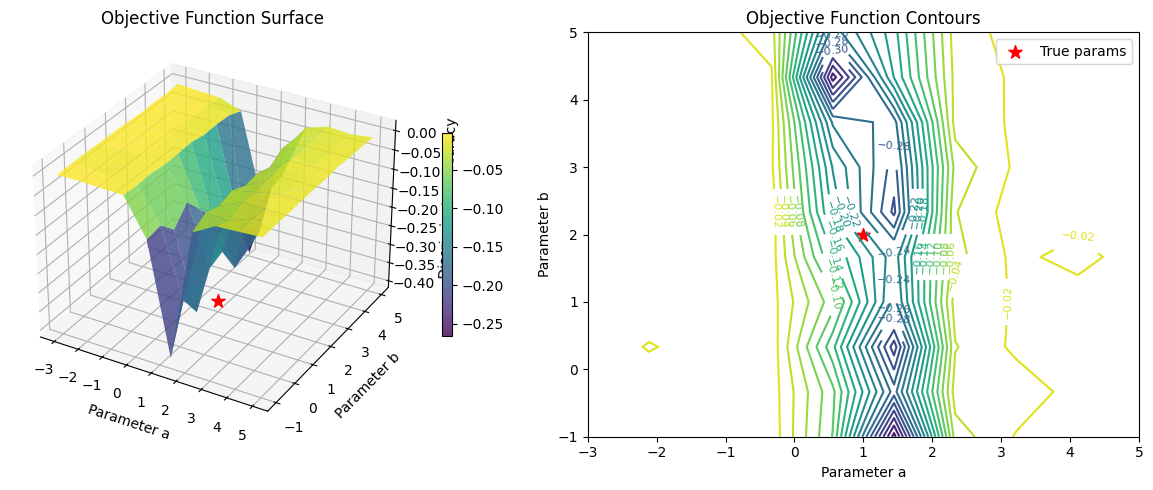


4. Running adversarial estimation...
Iteration No: 1 started. Evaluating function at random point.
Epoch 0, Loss: 0.5403
Epoch 1, Loss: 0.3631
Epoch 2, Loss: 0.2003
Epoch 3, Loss: 0.0815
Epoch 4, Loss: 0.0327
Epoch 5, Loss: 0.0150
Test objective (-CE) for theta=[6, -6]: -0.0106
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 9.5442
Function value obtained: -0.0106
Current minimum: -0.0106
Iteration No: 2 started. Evaluating function at random point.
Epoch 0, Loss: 0.5197
Epoch 1, Loss: 0.3235
Epoch 2, Loss: 0.1851
Epoch 3, Loss: 0.0786
Epoch 4, Loss: 0.0309
Epoch 5, Loss: 0.0140
Test objective (-CE) for theta=[6, 2]: -0.0098
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 6.4750
Function value obtained: -0.0098
Current minimum: -0.0106
Iteration No: 3 started. Evaluating function at random point.
Epoch 0, Loss: 0.5932
Epoch 1, Loss: 0.2831
Epoch 2, Loss: 0.1017
Epoch 3, Loss: 0.0375
Epoch 4, Loss: 0.0190
Epoch 5, Loss: 0.0121
Test objective (-CE

c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 3] before, using random point [2, 1]
  warnings.warn(


Epoch 0, Loss: 0.6555
Epoch 1, Loss: 0.5735
Epoch 2, Loss: 0.4496
Epoch 3, Loss: 0.2958
Epoch 4, Loss: 0.1686
Epoch 5, Loss: 0.0880
Test objective (-CE) for theta=[2, 1]: -0.0591
Iteration No: 73 ended. Search finished for the next optimal point.
Time taken: 7.4247
Function value obtained: -0.0591
Current minimum: -0.6945
Iteration No: 74 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 3] before, using random point [1, 9]
  warnings.warn(


Epoch 0, Loss: 0.7183
Epoch 1, Loss: 0.6591
Epoch 2, Loss: 0.6101
Epoch 3, Loss: 0.5440
Epoch 4, Loss: 0.4611
Epoch 5, Loss: 0.3715
Test objective (-CE) for theta=[1, 9]: -0.3225
Iteration No: 74 ended. Search finished for the next optimal point.
Time taken: 6.1016
Function value obtained: -0.3225
Current minimum: -0.6945
Iteration No: 75 started. Searching for the next optimal point.
Epoch 0, Loss: 0.6935
Epoch 1, Loss: 0.6916
Epoch 2, Loss: 0.6901
Epoch 3, Loss: 0.6864
Epoch 4, Loss: 0.6800
Epoch 5, Loss: 0.6721
Test objective (-CE) for theta=[1, 1]: -0.6668
Iteration No: 75 ended. Search finished for the next optimal point.
Time taken: 6.3844
Function value obtained: -0.6668
Current minimum: -0.6945
Iteration No: 76 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [-7, 8]
  warnings.warn(


Epoch 0, Loss: 0.4877
Epoch 1, Loss: 0.1318
Epoch 2, Loss: 0.0263
Epoch 3, Loss: 0.0078
Epoch 4, Loss: 0.0038
Epoch 5, Loss: 0.0026
Test objective (-CE) for theta=[-7, 8]: -0.0021
Iteration No: 76 ended. Search finished for the next optimal point.
Time taken: 6.0114
Function value obtained: -0.0021
Current minimum: -0.6945
Iteration No: 77 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [-9, 5]
  warnings.warn(


Epoch 0, Loss: 0.5372
Epoch 1, Loss: 0.1510
Epoch 2, Loss: 0.0340
Epoch 3, Loss: 0.0088
Epoch 4, Loss: 0.0039
Epoch 5, Loss: 0.0026
Test objective (-CE) for theta=[-9, 5]: -0.0021
Iteration No: 77 ended. Search finished for the next optimal point.
Time taken: 6.2009
Function value obtained: -0.0021
Current minimum: -0.6945
Iteration No: 78 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [3, 0]
  warnings.warn(


Epoch 0, Loss: 0.6934
Epoch 1, Loss: 0.5322
Epoch 2, Loss: 0.3348
Epoch 3, Loss: 0.1698
Epoch 4, Loss: 0.0751
Epoch 5, Loss: 0.0344
Test objective (-CE) for theta=[3, 0]: -0.0232
Iteration No: 78 ended. Search finished for the next optimal point.
Time taken: 6.1870
Function value obtained: -0.0232
Current minimum: -0.6945
Iteration No: 79 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [-9, 1]
  warnings.warn(


Epoch 0, Loss: 0.4077
Epoch 1, Loss: 0.1568
Epoch 2, Loss: 0.0610
Epoch 3, Loss: 0.0207
Epoch 4, Loss: 0.0086
Epoch 5, Loss: 0.0048
Test objective (-CE) for theta=[-9, 1]: -0.0038
Iteration No: 79 ended. Search finished for the next optimal point.
Time taken: 6.3131
Function value obtained: -0.0038
Current minimum: -0.6945
Iteration No: 80 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [-3, -8]
  warnings.warn(


Epoch 0, Loss: 0.4484
Epoch 1, Loss: 0.1285
Epoch 2, Loss: 0.0348
Epoch 3, Loss: 0.0126
Epoch 4, Loss: 0.0066
Epoch 5, Loss: 0.0044
Test objective (-CE) for theta=[-3, -8]: -0.0036
Iteration No: 80 ended. Search finished for the next optimal point.
Time taken: 6.8440
Function value obtained: -0.0036
Current minimum: -0.6945
Iteration No: 81 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [-5, -2]
  warnings.warn(


Epoch 0, Loss: 0.6284
Epoch 1, Loss: 0.2885
Epoch 2, Loss: 0.1382
Epoch 3, Loss: 0.0511
Epoch 4, Loss: 0.0186
Epoch 5, Loss: 0.0085
Test objective (-CE) for theta=[-5, -2]: -0.0063
Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 6.0908
Function value obtained: -0.0063
Current minimum: -0.6945
Iteration No: 82 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [-1, -7]
  warnings.warn(


Epoch 0, Loss: 0.5431
Epoch 1, Loss: 0.2874
Epoch 2, Loss: 0.1162
Epoch 3, Loss: 0.0428
Epoch 4, Loss: 0.0195
Epoch 5, Loss: 0.0111
Test objective (-CE) for theta=[-1, -7]: -0.0090
Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 6.1195
Function value obtained: -0.0090
Current minimum: -0.6945
Iteration No: 83 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [4, 4]
  warnings.warn(


Epoch 0, Loss: 0.5466
Epoch 1, Loss: 0.3940
Epoch 2, Loss: 0.2130
Epoch 3, Loss: 0.0862
Epoch 4, Loss: 0.0340
Epoch 5, Loss: 0.0157
Test objective (-CE) for theta=[4, 4]: -0.0111
Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 6.0991
Function value obtained: -0.0111
Current minimum: -0.6945
Iteration No: 84 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [2, 5]
  warnings.warn(


Epoch 0, Loss: 0.6561
Epoch 1, Loss: 0.5760
Epoch 2, Loss: 0.4757
Epoch 3, Loss: 0.3520
Epoch 4, Loss: 0.2363
Epoch 5, Loss: 0.1502
Test objective (-CE) for theta=[2, 5]: -0.1118
Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 6.3975
Function value obtained: -0.1118
Current minimum: -0.6945
Iteration No: 85 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [-9, 3]
  warnings.warn(


Epoch 0, Loss: 0.3970
Epoch 1, Loss: 0.1088
Epoch 2, Loss: 0.0303
Epoch 3, Loss: 0.0097
Epoch 4, Loss: 0.0046
Epoch 5, Loss: 0.0030
Test objective (-CE) for theta=[-9, 3]: -0.0026
Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 5.9997
Function value obtained: -0.0026
Current minimum: -0.6945
Iteration No: 86 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [7, -6]
  warnings.warn(


Epoch 0, Loss: 0.4713
Epoch 1, Loss: 0.3275
Epoch 2, Loss: 0.2010
Epoch 3, Loss: 0.0995
Epoch 4, Loss: 0.0428
Epoch 5, Loss: 0.0175
Test objective (-CE) for theta=[7, -6]: -0.0111
Iteration No: 86 ended. Search finished for the next optimal point.
Time taken: 6.0809
Function value obtained: -0.0111
Current minimum: -0.6945
Iteration No: 87 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [-3, -9]
  warnings.warn(


Epoch 0, Loss: 0.4526
Epoch 1, Loss: 0.1498
Epoch 2, Loss: 0.0383
Epoch 3, Loss: 0.0126
Epoch 4, Loss: 0.0061
Epoch 5, Loss: 0.0040
Test objective (-CE) for theta=[-3, -9]: -0.0031
Iteration No: 87 ended. Search finished for the next optimal point.
Time taken: 6.1800
Function value obtained: -0.0031
Current minimum: -0.6945
Iteration No: 88 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [-4, 10]
  warnings.warn(


Epoch 0, Loss: 0.5312
Epoch 1, Loss: 0.1913
Epoch 2, Loss: 0.0518
Epoch 3, Loss: 0.0160
Epoch 4, Loss: 0.0073
Epoch 5, Loss: 0.0046
Test objective (-CE) for theta=[-4, 10]: -0.0034
Iteration No: 88 ended. Search finished for the next optimal point.
Time taken: 6.0401
Function value obtained: -0.0034
Current minimum: -0.6945
Iteration No: 89 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [-8, 4]
  warnings.warn(


Epoch 0, Loss: 0.5087
Epoch 1, Loss: 0.1614
Epoch 2, Loss: 0.0495
Epoch 3, Loss: 0.0158
Epoch 4, Loss: 0.0069
Epoch 5, Loss: 0.0042
Test objective (-CE) for theta=[-8, 4]: -0.0034
Iteration No: 89 ended. Search finished for the next optimal point.
Time taken: 6.0735
Function value obtained: -0.0034
Current minimum: -0.6945
Iteration No: 90 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [2, -6]
  warnings.warn(


Epoch 0, Loss: 0.6654
Epoch 1, Loss: 0.5900
Epoch 2, Loss: 0.4901
Epoch 3, Loss: 0.3810
Epoch 4, Loss: 0.2864
Epoch 5, Loss: 0.2199
Test objective (-CE) for theta=[2, -6]: -0.1701
Iteration No: 90 ended. Search finished for the next optimal point.
Time taken: 6.7334
Function value obtained: -0.1701
Current minimum: -0.6945
Iteration No: 91 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [1, -8]
  warnings.warn(


Epoch 0, Loss: 0.6780
Epoch 1, Loss: 0.6224
Epoch 2, Loss: 0.5380
Epoch 3, Loss: 0.4410
Epoch 4, Loss: 0.3442
Epoch 5, Loss: 0.2671
Test objective (-CE) for theta=[1, -8]: -0.2421
Iteration No: 91 ended. Search finished for the next optimal point.
Time taken: 6.5945
Function value obtained: -0.2421
Current minimum: -0.6945
Iteration No: 92 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [-1, 3]
  warnings.warn(


Epoch 0, Loss: 0.4963
Epoch 1, Loss: 0.2296
Epoch 2, Loss: 0.0711
Epoch 3, Loss: 0.0218
Epoch 4, Loss: 0.0094
Epoch 5, Loss: 0.0055
Test objective (-CE) for theta=[-1, 3]: -0.0043
Iteration No: 92 ended. Search finished for the next optimal point.
Time taken: 6.1505
Function value obtained: -0.0043
Current minimum: -0.6945
Iteration No: 93 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [-2, -1]
  warnings.warn(


Epoch 0, Loss: 0.5703
Epoch 1, Loss: 0.2826
Epoch 2, Loss: 0.1320
Epoch 3, Loss: 0.0544
Epoch 4, Loss: 0.0236
Epoch 5, Loss: 0.0125
Test objective (-CE) for theta=[-2, -1]: -0.0097
Iteration No: 93 ended. Search finished for the next optimal point.
Time taken: 6.4529
Function value obtained: -0.0097
Current minimum: -0.6945
Iteration No: 94 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [2, -5]
  warnings.warn(


Epoch 0, Loss: 0.6442
Epoch 1, Loss: 0.5704
Epoch 2, Loss: 0.4669
Epoch 3, Loss: 0.3512
Epoch 4, Loss: 0.2581
Epoch 5, Loss: 0.1932
Test objective (-CE) for theta=[2, -5]: -0.1691
Iteration No: 94 ended. Search finished for the next optimal point.
Time taken: 6.1302
Function value obtained: -0.1691
Current minimum: -0.6945
Iteration No: 95 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [9, 7]
  warnings.warn(


Epoch 0, Loss: 0.4876
Epoch 1, Loss: 0.3028
Epoch 2, Loss: 0.1338
Epoch 3, Loss: 0.0437
Epoch 4, Loss: 0.0164
Epoch 5, Loss: 0.0079
Test objective (-CE) for theta=[9, 7]: -0.0058
Iteration No: 95 ended. Search finished for the next optimal point.
Time taken: 6.0862
Function value obtained: -0.0058
Current minimum: -0.6945
Iteration No: 96 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [-7, -1]
  warnings.warn(


Epoch 0, Loss: 0.3644
Epoch 1, Loss: 0.1097
Epoch 2, Loss: 0.0280
Epoch 3, Loss: 0.0086
Epoch 4, Loss: 0.0042
Epoch 5, Loss: 0.0027
Test objective (-CE) for theta=[-7, -1]: -0.0023
Iteration No: 96 ended. Search finished for the next optimal point.
Time taken: 6.0768
Function value obtained: -0.0023
Current minimum: -0.6945
Iteration No: 97 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [-10, 1]
  warnings.warn(


Epoch 0, Loss: 0.5084
Epoch 1, Loss: 0.1355
Epoch 2, Loss: 0.0315
Epoch 3, Loss: 0.0093
Epoch 4, Loss: 0.0043
Epoch 5, Loss: 0.0027
Test objective (-CE) for theta=[-10, 1]: -0.0023
Iteration No: 97 ended. Search finished for the next optimal point.
Time taken: 6.1196
Function value obtained: -0.0023
Current minimum: -0.6945
Iteration No: 98 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [-5, -8]
  warnings.warn(


Epoch 0, Loss: 0.5219
Epoch 1, Loss: 0.1809
Epoch 2, Loss: 0.0685
Epoch 3, Loss: 0.0230
Epoch 4, Loss: 0.0098
Epoch 5, Loss: 0.0056
Test objective (-CE) for theta=[-5, -8]: -0.0046
Iteration No: 98 ended. Search finished for the next optimal point.
Time taken: 6.1376
Function value obtained: -0.0046
Current minimum: -0.6945
Iteration No: 99 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [9, -8]
  warnings.warn(


Epoch 0, Loss: 0.4926
Epoch 1, Loss: 0.3137
Epoch 2, Loss: 0.1508
Epoch 3, Loss: 0.0552
Epoch 4, Loss: 0.0203
Epoch 5, Loss: 0.0093
Test objective (-CE) for theta=[9, -8]: -0.0068
Iteration No: 99 ended. Search finished for the next optimal point.
Time taken: 6.1999
Function value obtained: -0.0068
Current minimum: -0.6945
Iteration No: 100 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [9, 6]
  warnings.warn(


Epoch 0, Loss: 0.5319
Epoch 1, Loss: 0.2841
Epoch 2, Loss: 0.1215
Epoch 3, Loss: 0.0380
Epoch 4, Loss: 0.0140
Epoch 5, Loss: 0.0060
Test objective (-CE) for theta=[9, 6]: -0.0041
Iteration No: 100 ended. Search finished for the next optimal point.
Time taken: 6.1480
Function value obtained: -0.0041
Current minimum: -0.6945
Iteration No: 101 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [-10, -10]
  warnings.warn(


Epoch 0, Loss: 1.3748
Epoch 1, Loss: 0.4284
Epoch 2, Loss: 0.0869
Epoch 3, Loss: 0.0128
Epoch 4, Loss: 0.0039
Epoch 5, Loss: 0.0022
Test objective (-CE) for theta=[-10, -10]: -0.0017
Iteration No: 101 ended. Search finished for the next optimal point.
Time taken: 6.1355
Function value obtained: -0.0017
Current minimum: -0.6945
Iteration No: 102 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [4, -3]
  warnings.warn(


Epoch 0, Loss: 0.5931
Epoch 1, Loss: 0.4196
Epoch 2, Loss: 0.2451
Epoch 3, Loss: 0.1075
Epoch 4, Loss: 0.0449
Epoch 5, Loss: 0.0219
Test objective (-CE) for theta=[4, -3]: -0.0154
Iteration No: 102 ended. Search finished for the next optimal point.
Time taken: 6.1840
Function value obtained: -0.0154
Current minimum: -0.6945
Iteration No: 103 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [-8, 9]
  warnings.warn(


Epoch 0, Loss: 0.2415
Epoch 1, Loss: 0.0591
Epoch 2, Loss: 0.0136
Epoch 3, Loss: 0.0047
Epoch 4, Loss: 0.0025
Epoch 5, Loss: 0.0018
Test objective (-CE) for theta=[-8, 9]: -0.0016
Iteration No: 103 ended. Search finished for the next optimal point.
Time taken: 6.1240
Function value obtained: -0.0016
Current minimum: -0.6945
Iteration No: 104 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [-6, 8]
  warnings.warn(


Epoch 0, Loss: 0.3397
Epoch 1, Loss: 0.0777
Epoch 2, Loss: 0.0169
Epoch 3, Loss: 0.0057
Epoch 4, Loss: 0.0031
Epoch 5, Loss: 0.0022
Test objective (-CE) for theta=[-6, 8]: -0.0018
Iteration No: 104 ended. Search finished for the next optimal point.
Time taken: 6.2645
Function value obtained: -0.0018
Current minimum: -0.6945
Iteration No: 105 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [-2, 2]
  warnings.warn(


Epoch 0, Loss: 0.4736
Epoch 1, Loss: 0.1905
Epoch 2, Loss: 0.0570
Epoch 3, Loss: 0.0172
Epoch 4, Loss: 0.0071
Epoch 5, Loss: 0.0042
Test objective (-CE) for theta=[-2, 2]: -0.0032
Iteration No: 105 ended. Search finished for the next optimal point.
Time taken: 6.5842
Function value obtained: -0.0032
Current minimum: -0.6945
Iteration No: 106 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [7, -8]
  warnings.warn(


Epoch 0, Loss: 0.4496
Epoch 1, Loss: 0.2819
Epoch 2, Loss: 0.1364
Epoch 3, Loss: 0.0493
Epoch 4, Loss: 0.0196
Epoch 5, Loss: 0.0099
Test objective (-CE) for theta=[7, -8]: -0.0073
Iteration No: 106 ended. Search finished for the next optimal point.
Time taken: 6.1912
Function value obtained: -0.0073
Current minimum: -0.6945
Iteration No: 107 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [-3, -7]
  warnings.warn(


Epoch 0, Loss: 0.5240
Epoch 1, Loss: 0.2551
Epoch 2, Loss: 0.0853
Epoch 3, Loss: 0.0252
Epoch 4, Loss: 0.0094
Epoch 5, Loss: 0.0050
Test objective (-CE) for theta=[-3, -7]: -0.0036
Iteration No: 107 ended. Search finished for the next optimal point.
Time taken: 6.3676
Function value obtained: -0.0036
Current minimum: -0.6945
Iteration No: 108 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [9, 1]
  warnings.warn(


Epoch 0, Loss: 0.5467
Epoch 1, Loss: 0.3541
Epoch 2, Loss: 0.2126
Epoch 3, Loss: 0.1057
Epoch 4, Loss: 0.0469
Epoch 5, Loss: 0.0216
Test objective (-CE) for theta=[9, 1]: -0.0142
Iteration No: 108 ended. Search finished for the next optimal point.
Time taken: 6.3027
Function value obtained: -0.0142
Current minimum: -0.6945
Iteration No: 109 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 2] before, using random point [-1, 2]
  warnings.warn(


Epoch 0, Loss: 0.5268
Epoch 1, Loss: 0.2470
Epoch 2, Loss: 0.0785
Epoch 3, Loss: 0.0241
Epoch 4, Loss: 0.0102
Epoch 5, Loss: 0.0060
Test objective (-CE) for theta=[-1, 2]: -0.0045
Iteration No: 109 ended. Search finished for the next optimal point.
Time taken: 6.2200
Function value obtained: -0.0045
Current minimum: -0.6945
Iteration No: 110 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 2] before, using random point [-9, -7]
  warnings.warn(


Epoch 0, Loss: 0.2485
Epoch 1, Loss: 0.0922
Epoch 2, Loss: 0.0283
Epoch 3, Loss: 0.0091
Epoch 4, Loss: 0.0040
Epoch 5, Loss: 0.0024
Test objective (-CE) for theta=[-9, -7]: -0.0020
Iteration No: 110 ended. Search finished for the next optimal point.
Time taken: 6.1904
Function value obtained: -0.0020
Current minimum: -0.6945
Iteration No: 111 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 2] before, using random point [8, 9]
  warnings.warn(


Epoch 0, Loss: 0.4761
Epoch 1, Loss: 0.3319
Epoch 2, Loss: 0.1675
Epoch 3, Loss: 0.0610
Epoch 4, Loss: 0.0209
Epoch 5, Loss: 0.0096
Test objective (-CE) for theta=[8, 9]: -0.0068
Iteration No: 111 ended. Search finished for the next optimal point.
Time taken: 6.1342
Function value obtained: -0.0068
Current minimum: -0.6945
Iteration No: 112 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [4, 9]
  warnings.warn(


Epoch 0, Loss: 0.5356
Epoch 1, Loss: 0.3896
Epoch 2, Loss: 0.2609
Epoch 3, Loss: 0.1489
Epoch 4, Loss: 0.0791
Epoch 5, Loss: 0.0396
Test objective (-CE) for theta=[4, 9]: -0.0260
Iteration No: 112 ended. Search finished for the next optimal point.
Time taken: 6.1709
Function value obtained: -0.0260
Current minimum: -0.6945
Iteration No: 113 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [-2, 7]
  warnings.warn(


Epoch 0, Loss: 0.5669
Epoch 1, Loss: 0.2875
Epoch 2, Loss: 0.1064
Epoch 3, Loss: 0.0345
Epoch 4, Loss: 0.0143
Epoch 5, Loss: 0.0080
Test objective (-CE) for theta=[-2, 7]: -0.0063
Iteration No: 113 ended. Search finished for the next optimal point.
Time taken: 6.3947
Function value obtained: -0.0063
Current minimum: -0.6945
Iteration No: 114 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [-5, -5]
  warnings.warn(


Epoch 0, Loss: 0.5276
Epoch 1, Loss: 0.1989
Epoch 2, Loss: 0.0580
Epoch 3, Loss: 0.0172
Epoch 4, Loss: 0.0069
Epoch 5, Loss: 0.0040
Test objective (-CE) for theta=[-5, -5]: -0.0032
Iteration No: 114 ended. Search finished for the next optimal point.
Time taken: 6.3183
Function value obtained: -0.0032
Current minimum: -0.6945
Iteration No: 115 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [2, -9]
  warnings.warn(


Epoch 0, Loss: 0.6495
Epoch 1, Loss: 0.5895
Epoch 2, Loss: 0.5097
Epoch 3, Loss: 0.3983
Epoch 4, Loss: 0.2890
Epoch 5, Loss: 0.2026
Test objective (-CE) for theta=[2, -9]: -0.1594
Iteration No: 115 ended. Search finished for the next optimal point.
Time taken: 6.1336
Function value obtained: -0.1594
Current minimum: -0.6945
Iteration No: 116 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 2] before, using random point [7, 2]
  warnings.warn(


Epoch 0, Loss: 0.9128
Epoch 1, Loss: 0.5679
Epoch 2, Loss: 0.3707
Epoch 3, Loss: 0.1933
Epoch 4, Loss: 0.0783
Epoch 5, Loss: 0.0276
Test objective (-CE) for theta=[7, 2]: -0.0150
Iteration No: 116 ended. Search finished for the next optimal point.
Time taken: 6.1481
Function value obtained: -0.0150
Current minimum: -0.6945
Iteration No: 117 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 2] before, using random point [-9, 8]
  warnings.warn(


Epoch 0, Loss: 0.4533
Epoch 1, Loss: 0.1301
Epoch 2, Loss: 0.0444
Epoch 3, Loss: 0.0173
Epoch 4, Loss: 0.0090
Epoch 5, Loss: 0.0058
Test objective (-CE) for theta=[-9, 8]: -0.0046
Iteration No: 117 ended. Search finished for the next optimal point.
Time taken: 6.1830
Function value obtained: -0.0046
Current minimum: -0.6945
Iteration No: 118 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 2] before, using random point [-8, -3]
  warnings.warn(


Epoch 0, Loss: 0.3478
Epoch 1, Loss: 0.1025
Epoch 2, Loss: 0.0308
Epoch 3, Loss: 0.0107
Epoch 4, Loss: 0.0052
Epoch 5, Loss: 0.0033
Test objective (-CE) for theta=[-8, -3]: -0.0027
Iteration No: 118 ended. Search finished for the next optimal point.
Time taken: 7.6731
Function value obtained: -0.0027
Current minimum: -0.6945
Iteration No: 119 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 2] before, using random point [6, 0]
  warnings.warn(


Epoch 0, Loss: 0.6392
Epoch 1, Loss: 0.3792
Epoch 2, Loss: 0.2088
Epoch 3, Loss: 0.0970
Epoch 4, Loss: 0.0428
Epoch 5, Loss: 0.0205
Test objective (-CE) for theta=[6, 0]: -0.0149
Iteration No: 119 ended. Search finished for the next optimal point.
Time taken: 7.2085
Function value obtained: -0.0149
Current minimum: -0.6945
Iteration No: 120 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 2] before, using random point [-7, -7]
  warnings.warn(


Epoch 0, Loss: 0.4107
Epoch 1, Loss: 0.1467
Epoch 2, Loss: 0.0460
Epoch 3, Loss: 0.0142
Epoch 4, Loss: 0.0059
Epoch 5, Loss: 0.0035
Test objective (-CE) for theta=[-7, -7]: -0.0029
Iteration No: 120 ended. Search finished for the next optimal point.
Time taken: 8.2336
Function value obtained: -0.0029
Current minimum: -0.6945
Iteration No: 121 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 2] before, using random point [-2, -10]
  warnings.warn(


Epoch 0, Loss: 0.3946
Epoch 1, Loss: 0.1184
Epoch 2, Loss: 0.0312
Epoch 3, Loss: 0.0120
Epoch 4, Loss: 0.0065
Epoch 5, Loss: 0.0046
Test objective (-CE) for theta=[-2, -10]: -0.0043
Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 9.1381
Function value obtained: -0.0043
Current minimum: -0.6945
Iteration No: 122 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 2] before, using random point [-2, -7]
  warnings.warn(


Epoch 0, Loss: 0.4904
Epoch 1, Loss: 0.1935
Epoch 2, Loss: 0.0530
Epoch 3, Loss: 0.0158
Epoch 4, Loss: 0.0071
Epoch 5, Loss: 0.0044
Test objective (-CE) for theta=[-2, -7]: -0.0035
Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 8.3946
Function value obtained: -0.0035
Current minimum: -0.6945
Iteration No: 123 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 2] before, using random point [-2, -4]
  warnings.warn(


Epoch 0, Loss: 0.3655
Epoch 1, Loss: 0.1230
Epoch 2, Loss: 0.0284
Epoch 3, Loss: 0.0081
Epoch 4, Loss: 0.0037
Epoch 5, Loss: 0.0024
Test objective (-CE) for theta=[-2, -4]: -0.0019
Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 8.0950
Function value obtained: -0.0019
Current minimum: -0.6945
Iteration No: 124 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 2] before, using random point [3, 9]
  warnings.warn(


Epoch 0, Loss: 0.5570
Epoch 1, Loss: 0.3862
Epoch 2, Loss: 0.2199
Epoch 3, Loss: 0.1051
Epoch 4, Loss: 0.0510
Epoch 5, Loss: 0.0277
Test objective (-CE) for theta=[3, 9]: -0.0232
Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 7.5889
Function value obtained: -0.0232
Current minimum: -0.6945
Iteration No: 125 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 2] before, using random point [1, 10]
  warnings.warn(


Epoch 0, Loss: 0.6828
Epoch 1, Loss: 0.6250
Epoch 2, Loss: 0.5307
Epoch 3, Loss: 0.4027
Epoch 4, Loss: 0.2778
Epoch 5, Loss: 0.1832
Test objective (-CE) for theta=[1, 10]: -0.1418
Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 8.6239
Function value obtained: -0.1418
Current minimum: -0.6945
Iteration No: 126 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [-1, -3]
  warnings.warn(


Epoch 0, Loss: 0.5796
Epoch 1, Loss: 0.2924
Epoch 2, Loss: 0.1031
Epoch 3, Loss: 0.0316
Epoch 4, Loss: 0.0128
Epoch 5, Loss: 0.0072
Test objective (-CE) for theta=[-1, -3]: -0.0058
Iteration No: 126 ended. Search finished for the next optimal point.
Time taken: 7.8599
Function value obtained: -0.0058
Current minimum: -0.6945
Iteration No: 127 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [-7, 0]
  warnings.warn(


Epoch 0, Loss: 0.3926
Epoch 1, Loss: 0.1429
Epoch 2, Loss: 0.0457
Epoch 3, Loss: 0.0141
Epoch 4, Loss: 0.0059
Epoch 5, Loss: 0.0034
Test objective (-CE) for theta=[-7, 0]: -0.0027
Iteration No: 127 ended. Search finished for the next optimal point.
Time taken: 8.5852
Function value obtained: -0.0027
Current minimum: -0.6945
Iteration No: 128 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [-4, 5]
  warnings.warn(


Epoch 0, Loss: 0.5010
Epoch 1, Loss: 0.1445
Epoch 2, Loss: 0.0375
Epoch 3, Loss: 0.0123
Epoch 4, Loss: 0.0061
Epoch 5, Loss: 0.0040
Test objective (-CE) for theta=[-4, 5]: -0.0034
Iteration No: 128 ended. Search finished for the next optimal point.
Time taken: 6.4494
Function value obtained: -0.0034
Current minimum: -0.6945
Iteration No: 129 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [5, 9]
  warnings.warn(


Epoch 0, Loss: 0.5937
Epoch 1, Loss: 0.4380
Epoch 2, Loss: 0.2908
Epoch 3, Loss: 0.1490
Epoch 4, Loss: 0.0691
Epoch 5, Loss: 0.0335
Test objective (-CE) for theta=[5, 9]: -0.0239
Iteration No: 129 ended. Search finished for the next optimal point.
Time taken: 6.2673
Function value obtained: -0.0239
Current minimum: -0.6945
Iteration No: 130 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [9, -9]
  warnings.warn(


Epoch 0, Loss: 0.4506
Epoch 1, Loss: 0.2876
Epoch 2, Loss: 0.1223
Epoch 3, Loss: 0.0331
Epoch 4, Loss: 0.0098
Epoch 5, Loss: 0.0042
Test objective (-CE) for theta=[9, -9]: -0.0029
Iteration No: 130 ended. Search finished for the next optimal point.
Time taken: 6.7270
Function value obtained: -0.0029
Current minimum: -0.6945
Iteration No: 131 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [5, 8]
  warnings.warn(


Epoch 0, Loss: 0.5060
Epoch 1, Loss: 0.3339
Epoch 2, Loss: 0.1594
Epoch 3, Loss: 0.0525
Epoch 4, Loss: 0.0190
Epoch 5, Loss: 0.0092
Test objective (-CE) for theta=[5, 8]: -0.0067
Iteration No: 131 ended. Search finished for the next optimal point.
Time taken: 6.4037
Function value obtained: -0.0067
Current minimum: -0.6945
Iteration No: 132 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [0, -4]
  warnings.warn(


Epoch 0, Loss: 0.5747
Epoch 1, Loss: 0.3698
Epoch 2, Loss: 0.1920
Epoch 3, Loss: 0.0878
Epoch 4, Loss: 0.0443
Epoch 5, Loss: 0.0268
Test objective (-CE) for theta=[0, -4]: -0.0205
Iteration No: 132 ended. Search finished for the next optimal point.
Time taken: 6.4585
Function value obtained: -0.0205
Current minimum: -0.6945
Iteration No: 133 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [2, 1]
  warnings.warn(


Epoch 0, Loss: 0.6463
Epoch 1, Loss: 0.5638
Epoch 2, Loss: 0.4671
Epoch 3, Loss: 0.3370
Epoch 4, Loss: 0.2085
Epoch 5, Loss: 0.1156
Test objective (-CE) for theta=[2, 1]: -0.0778
Iteration No: 133 ended. Search finished for the next optimal point.
Time taken: 6.4795
Function value obtained: -0.0778
Current minimum: -0.6945
Iteration No: 134 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [7, 7]
  warnings.warn(


Epoch 0, Loss: 0.4585
Epoch 1, Loss: 0.2817
Epoch 2, Loss: 0.1232
Epoch 3, Loss: 0.0393
Epoch 4, Loss: 0.0149
Epoch 5, Loss: 0.0076
Test objective (-CE) for theta=[7, 7]: -0.0058
Iteration No: 134 ended. Search finished for the next optimal point.
Time taken: 6.6591
Function value obtained: -0.0058
Current minimum: -0.6945
Iteration No: 135 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [5, 3]
  warnings.warn(


Epoch 0, Loss: 0.4941
Epoch 1, Loss: 0.3419
Epoch 2, Loss: 0.2029
Epoch 3, Loss: 0.0933
Epoch 4, Loss: 0.0391
Epoch 5, Loss: 0.0171
Test objective (-CE) for theta=[5, 3]: -0.0115
Iteration No: 135 ended. Search finished for the next optimal point.
Time taken: 6.5698
Function value obtained: -0.0115
Current minimum: -0.6945
Iteration No: 136 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [4, -9]
  warnings.warn(


Epoch 0, Loss: 0.6199
Epoch 1, Loss: 0.4606
Epoch 2, Loss: 0.2977
Epoch 3, Loss: 0.1565
Epoch 4, Loss: 0.0733
Epoch 5, Loss: 0.0380
Test objective (-CE) for theta=[4, -9]: -0.0251
Iteration No: 136 ended. Search finished for the next optimal point.
Time taken: 6.5398
Function value obtained: -0.0251
Current minimum: -0.6945
Iteration No: 137 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [6, 9]
  warnings.warn(


Epoch 0, Loss: 0.6743
Epoch 1, Loss: 0.4088
Epoch 2, Loss: 0.2530
Epoch 3, Loss: 0.1449
Epoch 4, Loss: 0.0758
Epoch 5, Loss: 0.0412
Test objective (-CE) for theta=[6, 9]: -0.0302
Iteration No: 137 ended. Search finished for the next optimal point.
Time taken: 6.5393
Function value obtained: -0.0302
Current minimum: -0.6945
Iteration No: 138 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [7, 2]
  warnings.warn(


Epoch 0, Loss: 0.6394
Epoch 1, Loss: 0.4060
Epoch 2, Loss: 0.2294
Epoch 3, Loss: 0.0993
Epoch 4, Loss: 0.0373
Epoch 5, Loss: 0.0163
Test objective (-CE) for theta=[7, 2]: -0.0110
Iteration No: 138 ended. Search finished for the next optimal point.
Time taken: 6.5213
Function value obtained: -0.0110
Current minimum: -0.6945
Iteration No: 139 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [-8, 9]
  warnings.warn(


Epoch 0, Loss: 0.3689
Epoch 1, Loss: 0.1203
Epoch 2, Loss: 0.0307
Epoch 3, Loss: 0.0086
Epoch 4, Loss: 0.0039
Epoch 5, Loss: 0.0025
Test objective (-CE) for theta=[-8, 9]: -0.0021
Iteration No: 139 ended. Search finished for the next optimal point.
Time taken: 6.5295
Function value obtained: -0.0021
Current minimum: -0.6945
Iteration No: 140 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [-9, 5]
  warnings.warn(


Epoch 0, Loss: 0.2869
Epoch 1, Loss: 0.1100
Epoch 2, Loss: 0.0285
Epoch 3, Loss: 0.0080
Epoch 4, Loss: 0.0034
Epoch 5, Loss: 0.0021
Test objective (-CE) for theta=[-9, 5]: -0.0017
Iteration No: 140 ended. Search finished for the next optimal point.
Time taken: 6.6168
Function value obtained: -0.0017
Current minimum: -0.6945
Iteration No: 141 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [1, -3]
  warnings.warn(


Epoch 0, Loss: 0.6949
Epoch 1, Loss: 0.6802
Epoch 2, Loss: 0.6617
Epoch 3, Loss: 0.6381
Epoch 4, Loss: 0.6051
Epoch 5, Loss: 0.5682
Test objective (-CE) for theta=[1, -3]: -0.5488
Iteration No: 141 ended. Search finished for the next optimal point.
Time taken: 6.4683
Function value obtained: -0.5488
Current minimum: -0.6945
Iteration No: 142 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [-8, -10]
  warnings.warn(


Epoch 0, Loss: 0.5429
Epoch 1, Loss: 0.2082
Epoch 2, Loss: 0.0829
Epoch 3, Loss: 0.0302
Epoch 4, Loss: 0.0131
Epoch 5, Loss: 0.0073
Test objective (-CE) for theta=[-8, -10]: -0.0058
Iteration No: 142 ended. Search finished for the next optimal point.
Time taken: 6.5290
Function value obtained: -0.0058
Current minimum: -0.6945
Iteration No: 143 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [-5, 9]
  warnings.warn(


Epoch 0, Loss: 0.3622
Epoch 1, Loss: 0.0941
Epoch 2, Loss: 0.0253
Epoch 3, Loss: 0.0085
Epoch 4, Loss: 0.0043
Epoch 5, Loss: 0.0029
Test objective (-CE) for theta=[-5, 9]: -0.0024
Iteration No: 143 ended. Search finished for the next optimal point.
Time taken: 6.7660
Function value obtained: -0.0024
Current minimum: -0.6945
Iteration No: 144 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [0, 2]
  warnings.warn(


Epoch 0, Loss: 0.6354
Epoch 1, Loss: 0.4842
Epoch 2, Loss: 0.2835
Epoch 3, Loss: 0.1282
Epoch 4, Loss: 0.0531
Epoch 5, Loss: 0.0259
Test objective (-CE) for theta=[0, 2]: -0.0177
Iteration No: 144 ended. Search finished for the next optimal point.
Time taken: 6.4956
Function value obtained: -0.0177
Current minimum: -0.6945
Iteration No: 145 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [-7, -1]
  warnings.warn(


Epoch 0, Loss: 0.3569
Epoch 1, Loss: 0.0835
Epoch 2, Loss: 0.0175
Epoch 3, Loss: 0.0055
Epoch 4, Loss: 0.0029
Epoch 5, Loss: 0.0020
Test objective (-CE) for theta=[-7, -1]: -0.0018
Iteration No: 145 ended. Search finished for the next optimal point.
Time taken: 6.6031
Function value obtained: -0.0018
Current minimum: -0.6945
Iteration No: 146 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [-10, -5]
  warnings.warn(


Epoch 0, Loss: 0.4619
Epoch 1, Loss: 0.1973
Epoch 2, Loss: 0.0845
Epoch 3, Loss: 0.0320
Epoch 4, Loss: 0.0137
Epoch 5, Loss: 0.0074
Test objective (-CE) for theta=[-10, -5]: -0.0058
Iteration No: 146 ended. Search finished for the next optimal point.
Time taken: 6.5105
Function value obtained: -0.0058
Current minimum: -0.6945
Iteration No: 147 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [9, 8]
  warnings.warn(


Epoch 0, Loss: 0.4396
Epoch 1, Loss: 0.2413
Epoch 2, Loss: 0.1046
Epoch 3, Loss: 0.0358
Epoch 4, Loss: 0.0139
Epoch 5, Loss: 0.0072
Test objective (-CE) for theta=[9, 8]: -0.0053
Iteration No: 147 ended. Search finished for the next optimal point.
Time taken: 6.6136
Function value obtained: -0.0053
Current minimum: -0.6945
Iteration No: 148 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [-8, -4]
  warnings.warn(


Epoch 0, Loss: 0.5209
Epoch 1, Loss: 0.3449
Epoch 2, Loss: 0.2251
Epoch 3, Loss: 0.1054
Epoch 4, Loss: 0.0347
Epoch 5, Loss: 0.0117
Test objective (-CE) for theta=[-8, -4]: -0.0073
Iteration No: 148 ended. Search finished for the next optimal point.
Time taken: 6.5235
Function value obtained: -0.0073
Current minimum: -0.6945
Iteration No: 149 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [6, -1]
  warnings.warn(


Epoch 0, Loss: 0.4193
Epoch 1, Loss: 0.2889
Epoch 2, Loss: 0.1564
Epoch 3, Loss: 0.0658
Epoch 4, Loss: 0.0273
Epoch 5, Loss: 0.0134
Test objective (-CE) for theta=[6, -1]: -0.0098
Iteration No: 149 ended. Search finished for the next optimal point.
Time taken: 6.5804
Function value obtained: -0.0098
Current minimum: -0.6945
Iteration No: 150 started. Searching for the next optimal point.


c:\Users\vitil\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 1] before, using random point [3, 9]
  warnings.warn(


Epoch 0, Loss: 0.5016
Epoch 1, Loss: 0.3758
Epoch 2, Loss: 0.2585
Epoch 3, Loss: 0.1527
Epoch 4, Loss: 0.0796
Epoch 5, Loss: 0.0412
Test objective (-CE) for theta=[3, 9]: -0.0297
Iteration No: 150 ended. Search finished for the next optimal point.
Time taken: 6.5864
Function value obtained: -0.0297
Current minimum: -0.6945

5. Results:
   - True parameters: a=1.0, b=2.0
   - Estimated parameters: a=1.0000, b=2.0000
   - Estimation error: a_error=0.0000, b_error=0.0000


<Figure size 640x480 with 0 Axes>

In [12]:
if __name__ == "__main__":
    
    print("Testing Adversarial Estimation for Linear-in-Means Model")
    print("=" * 60)
    true_params = [1.0, 2.0]
    print("\n1. Generating test dataset...")
    test_data = create_test_graph_dataset(num_nodes=N_NODES, true_a=true_params[0], true_b=true_params[1], p=P)

    print("\n2. Creating adversarial estimator...")
    estimator = AdversarialEstimator(
        ground_truth_data=test_data,
        structural_model=linear_in_means_model,
        initial_params=[0.0, 0.0],
        bounds=[(-10, 10), (-10, 10)],
        discriminator_factory=discriminator_factory
    )

    print("\n3. Visualizing objective function surface...")

    visualize_objective_surface(
        estimator,
        m=N_SAMPLES,
        resolution=RESOLUTION,
        num_epochs=N_EPOCHS,
        verbose=True,
    )


    print("\n4. Running adversarial estimation...")
    result = estimator.estimate(m=N_SAMPLES, num_epochs=N_EPOCHS, verbose=True)
    estimated_params = result['x'] if isinstance(result, dict) else result.x
    estimator.estimated_params = estimated_params

    print("\n5. Results:")
    print(f"   - True parameters: a={true_params[0]}, b={true_params[1]}")
    print(f"   - Estimated parameters: a={estimated_params[0]:.4f}, b={estimated_params[1]:.4f}")
    print(
        f"   - Estimation error: a_error={abs(estimated_params[0] - true_params[0]):.4f}, "
        f"b_error={abs(estimated_params[1] - true_params[1]):.4f}"
    )

    plt.tight_layout()
    plt.show()